<a href="https://colab.research.google.com/github/pabair/ml-kurs-ss21/blob/master/8_PyTorch_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Digits Example
This example classifies the digit dataset using a neural net.
For more details on the dataset, check [this](https://github.com/pabair/ml-kurs-ss21/blob/master/2_Logistische_Regression_Digits.ipynb) notebook.



Install with `conda install pytorch` or `pip3 install torch`

### 0. Preamble

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(1)
np.random.seed(1)

In [2]:
if(torch.cuda.is_available()):
  processing_chip = "cuda:0"
  print(f"{torch.cuda.get_device_name(0)} available")
else:
  processing_chip = "cpu"
  print("No GPU available")

device = torch.device(processing_chip)
device

No GPU available


device(type='cpu')

### 1. Data Preperation

In [3]:
from sklearn.datasets import load_digits
data, labels = load_digits(return_X_y = True)

In [4]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data, labels, test_size=0.2, random_state=0)

In [5]:
train_X

array([[ 0.,  0.,  0., ..., 16., 16.,  6.],
       [ 0.,  3., 12., ..., 16.,  2.,  0.],
       [ 0.,  1., 10., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  4., ...,  0.,  0.,  0.],
       [ 0.,  0.,  6., ..., 11.,  0.,  0.]])

In [6]:
train_x = torch.Tensor(train_X).float().to(device)
test_x = torch.Tensor(test_X).float().to(device)
train_y =torch.Tensor(train_y).long().to(device)
test_y = torch.Tensor(test_y).long().to(device)

### 2. Model definition 


In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hidden1 = nn.Linear(64, 5)
    self.hidden2 = nn.Linear(5, 7)  
    self.output = nn.Linear(7, 10)

  def forward(self, x):
    z = F.relu(self.hidden1(x))
    z = F.relu(self.hidden2(z))
    z = self.output(z)  # no softmax. see CrossEntropyLoss() 
    return z

### 3. Model Training

In [8]:
# create network, move it to device and set it to training-mode
net = Net().to(device)
net.train()

# define the parameters for training
no_epochs = 5000
learning_rate = 0.01
loss_func = nn.CrossEntropyLoss()  # applies softmax() internally
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

print("\nStarting training ")

train_losses = []
for epoch in range(0, no_epochs):

  optimizer.zero_grad()
  output = net(train_x)

  loss = loss_func(output, train_y)
  loss.backward()
  optimizer.step()

  train_losses.append(loss.item())
  
  if epoch % 10 == 0:
    print(f"Loss in epoch {epoch} is {loss.item()}")

print("Done training ")


Starting training 
Loss in epoch 0 is 2.483743906021118
Loss in epoch 10 is 2.2992963790893555
Loss in epoch 20 is 2.2463860511779785
Loss in epoch 30 is 2.206214666366577
Loss in epoch 40 is 2.1667559146881104
Loss in epoch 50 is 2.1252381801605225
Loss in epoch 60 is 2.081197500228882
Loss in epoch 70 is 2.034482002258301
Loss in epoch 80 is 1.9860403537750244
Loss in epoch 90 is 1.9372819662094116
Loss in epoch 100 is 1.8889433145523071
Loss in epoch 110 is 1.8417812585830688
Loss in epoch 120 is 1.7961574792861938
Loss in epoch 130 is 1.7513185739517212
Loss in epoch 140 is 1.7079929113388062
Loss in epoch 150 is 1.666191577911377
Loss in epoch 160 is 1.626001238822937
Loss in epoch 170 is 1.5874701738357544
Loss in epoch 180 is 1.5508407354354858
Loss in epoch 190 is 1.5158514976501465
Loss in epoch 200 is 1.482245683670044
Loss in epoch 210 is 1.4499735832214355
Loss in epoch 220 is 1.4189561605453491
Loss in epoch 230 is 1.3894200325012207
Loss in epoch 240 is 1.361213922500610

Loss in epoch 2130 is 0.23387177288532257
Loss in epoch 2140 is 0.23233351111412048
Loss in epoch 2150 is 0.23084405064582825
Loss in epoch 2160 is 0.2294001281261444
Loss in epoch 2170 is 0.22798959910869598
Loss in epoch 2180 is 0.22660359740257263
Loss in epoch 2190 is 0.2252393513917923
Loss in epoch 2200 is 0.22388175129890442
Loss in epoch 2210 is 0.22253422439098358
Loss in epoch 2220 is 0.22119958698749542
Loss in epoch 2230 is 0.2198723405599594
Loss in epoch 2240 is 0.21854782104492188
Loss in epoch 2250 is 0.2172093391418457
Loss in epoch 2260 is 0.2158353328704834
Loss in epoch 2270 is 0.21447932720184326
Loss in epoch 2280 is 0.2131522297859192
Loss in epoch 2290 is 0.21184180676937103
Loss in epoch 2300 is 0.21053706109523773
Loss in epoch 2310 is 0.20921604335308075
Loss in epoch 2320 is 0.2078987956047058
Loss in epoch 2330 is 0.2066085934638977
Loss in epoch 2340 is 0.2053069770336151
Loss in epoch 2350 is 0.2040100246667862
Loss in epoch 2360 is 0.20273225009441376
Lo

Loss in epoch 4160 is 0.10244029015302658
Loss in epoch 4170 is 0.10220978409051895
Loss in epoch 4180 is 0.10197938233613968
Loss in epoch 4190 is 0.10174968093633652
Loss in epoch 4200 is 0.10152164846658707
Loss in epoch 4210 is 0.10129224509000778
Loss in epoch 4220 is 0.10104579478502274
Loss in epoch 4230 is 0.10080566257238388
Loss in epoch 4240 is 0.10056494176387787
Loss in epoch 4250 is 0.10032095015048981
Loss in epoch 4260 is 0.10006910562515259
Loss in epoch 4270 is 0.09982242435216904
Loss in epoch 4280 is 0.09957393258810043
Loss in epoch 4290 is 0.09933195263147354
Loss in epoch 4300 is 0.0990954264998436
Loss in epoch 4310 is 0.09885694086551666
Loss in epoch 4320 is 0.09862133115530014
Loss in epoch 4330 is 0.09838885068893433
Loss in epoch 4340 is 0.0981563851237297
Loss in epoch 4350 is 0.09793128818273544
Loss in epoch 4360 is 0.09770354628562927
Loss in epoch 4370 is 0.09748196601867676
Loss in epoch 4380 is 0.09725665301084518
Loss in epoch 4390 is 0.097012035548

Text(0, 0.5, 'loss')

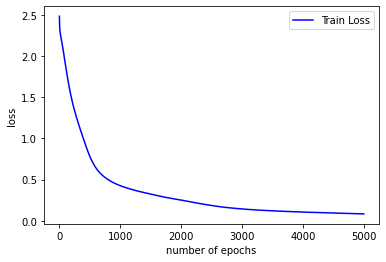

In [9]:
  fig = plt.figure()
  plt.plot(range(0, no_epochs), train_losses, color='blue')
  plt.legend(['Train Loss'], loc='upper right')
  plt.xlabel('number of epochs')
  plt.ylabel('loss')

### 4. Model Evaluation

In [10]:
net.eval() # set network to evaluation mode
y_pred = net(test_x)
_, predicted = torch.max(y_pred.data, 1)
correct = (predicted == test_y).sum().item()
print(f"Accuarcy is {100. * correct / len(test_x)}%")

Accuarcy is 90.83333333333333%
